# Exploring NOAA GSOD Weather Stations

The US National Oceanic and Atmospheric Administration (NOAA) publishes climate data through the National Centers for Environmental Information (NCEI), with daily measurements called the [Global \[Surface\] Summary of Day (GSOD)](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516). Per this page, "The data are reported and summarized based on Greenwich Mean Time (GMT, 0000Z - 2359Z) since the original synoptic/hourly data are reported and based on GMT." 

The data is available in many forms, including raw CSV [here](https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/). This is organized by year, and then by a file per data-collecting station. The stations are identified by a combination of USAF (Air Force station ID) and WBAN (NCDC (National Climatic Data Center) Weather Bureau Army Navy number) identifiers. These stations are further located by latitude and longitude in this stations list file: [https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv) (and in [txt](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.txt) format)

Total number of stations: 9479


<Axes: xlabel='LON', ylabel='LAT'>

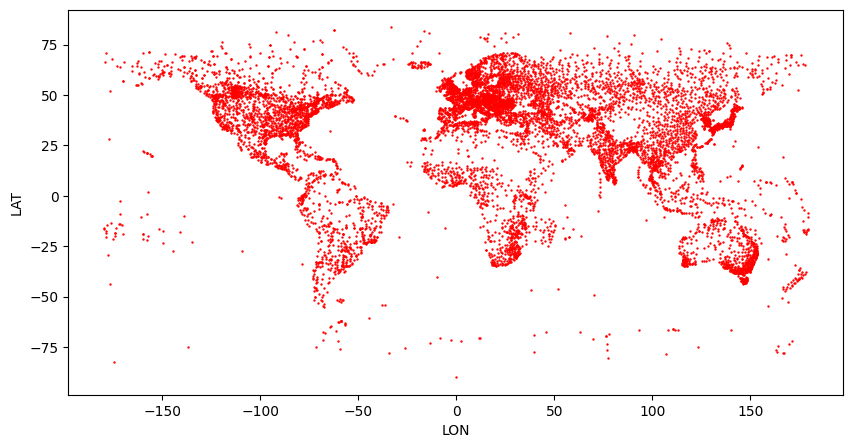

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

stations = pd.read_csv('https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv', dtype={'BEGIN': 'string', 'END': 'string'})

# Only include stations that have values for Latitude, Longitude, and Country
stations.dropna(subset=['LAT', 'LON', 'CTRY'], inplace=True)

# Let's make further calculations easier by extracting the begin and end years of recorded data to integers
stations['begin_year'] = stations['BEGIN'].str.slice(0, 4).astype(int)
stations['end_year'] = stations['END'].str.slice(0, 4).astype(int)

# Only include stations that have current data and have at least 20 years of history
stations = stations[(stations['end_year'] == 2024) & (stations['begin_year'] <= 2005)].copy()

# Convert LAT/LON to floats
stations['LAT'] = pd.to_numeric(stations['LAT'], errors='coerce')
stations['LON'] = pd.to_numeric(stations['LON'], errors='coerce')

# How many stations do we have?
print(f"Total number of stations: {stations.shape[0]}")

# Let's plot with just matplotlib using latitude/longitude on a graph and see how that looks
stations.plot(x = 'LON', y = 'LAT', kind = 'scatter', s = 0.5, c = 'red')

Let's restrict further to just stations in the 50 US states.

Total number of US stations: 910


<Axes: xlabel='LON', ylabel='LAT'>

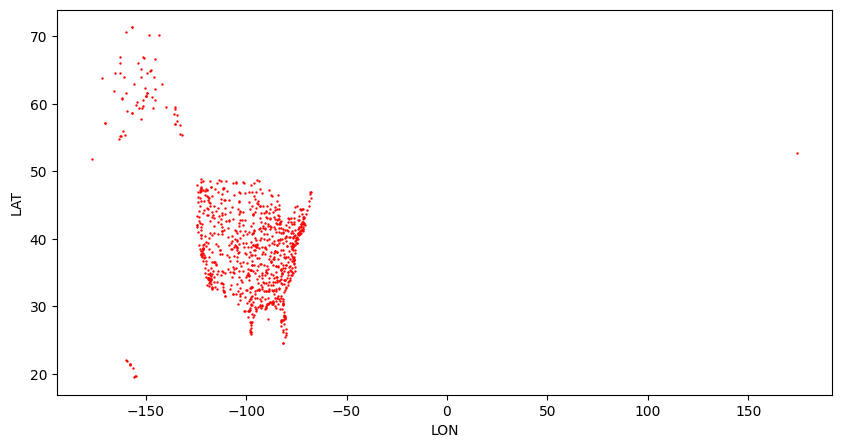

In [2]:
states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 
          'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 
          'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 
          'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
          'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
stations = stations[(stations['CTRY'] == 'US') & (stations['STATE'].notna()) & (stations['STATE'].isin(states))].copy()
print(f"Total number of US stations: {stations.shape[0]}")
stations.plot(x = 'LON', y = 'LAT', kind='scatter', s = 0.5, c = 'red')

This looks great, but what's going on with that station to the far right? It claims to be one of the 50 states, but it's clearly not located there. Let's use ipyleaflet to create an interactive map to inspect this point visually.

In [9]:
from folium import Map, Marker

map = Map(location = (41.868, -87.665), 
          zoom_start = 1,
          tiles="cartodb positron")

for index, station in stations.iterrows():
    station_popup = f"""
{station['STATION NAME']}
{station['STATE']}
({station['LAT']}, {station['LON']})
{station['begin_year']} - {station['end_year']}
"""
    Marker(location = (station['LAT'], station['LON']), 
           draggable = False, 
           popup = station_popup).add_to(map)

display(map)

This station is "EARECKSON AIR STATION AIRPORT" belonging to Alaska: https://en.wikipedia.org/wiki/Eareckson_Air_Station

This is located at the westernmost point in Alaska and has a longitude of 174.1, which is past the Antimeridian: https://en.wikipedia.org/wiki/180th_meridian

This explains why it appears at the far right position in the naive matplotlib-based plot of the station coordinates, but is still part of the 50 states.

Now I want to do analysis on climate data for Chicago year over year, so I want to find a station in the Chicago area with the greatest year-over-year coverage of data (maximum days per year of data). 

More details about the formats of these GSOD data files can be found in the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt).

Taking the latitude/longitude of the approximate center of Chicago per [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Chicago,_Illinois#:~:text=Chicago%20is%20a%20city%20in,%C2%B039%E2%80%B254.00%E2%80%B3%20West.) as `(41.868, -87.665)`, we can find the closest station using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) for great circle distances. 

In [51]:
def distanceToChicago(station):
    chicagoLatLong = (41.868, -87.665)
    return haversine((station['LAT'], station['LON']), chicagoLatLong)

stations['distance_to_chicago'] = stations.apply(distanceToChicago, axis=1)
print(stations[stations['distance_to_chicago'] < 100])

         USAF   WBAN                          STATION NAME CTRY STATE  ICAO  \
20027  725300  94846  CHICAGO O'HARE INTERNATIONAL AIRPORT   US    IL  KORD   
20060  725340  14819              CHICAGO MIDWAY INTL ARPT   US    IL  KMDW   
20064  725345  14834               JOLIET REGIONAL AIRPORT   US    IL  KJOT   
29317  999999  54811                        SHABBONA 5 NNE   US    IL   NaN   

          LAT     LON  ELEV(M)     BEGIN       END  begin_year  end_year  \
20027  41.960 -87.932    204.8  19461001  20240319        1946      2024   
20060  41.784 -87.755    185.8  19730101  20240318        1973      2024   
20064  41.500 -88.167    177.4  20020902  20240318        2002      2024   
29317  41.843 -88.851    262.4  20030816  20240318        2003      2024   

       distance_to_chicago  
20027            24.346570  
20060            11.952200  
20064            58.414596  
29317            98.264764  


Visually inspecting this, I see the two stations with the highest date coverage and the closest distance to Chicago are "CHICAGO MIDWAY INTL ARPT" and "CHICAGO O'HARE INTERNATIONAL AIRPORT".

Later we'll need to confirm quality and coverage of data with the actual data files.

In [52]:
chicagoStations = stations[stations['STATION NAME'].isin(['CHICAGO MIDWAY INTL ARPT', 'CHICAGO O\'HARE INTERNATIONAL AIRPORT'])]
print(chicagoStations)

         USAF   WBAN                          STATION NAME CTRY STATE  ICAO  \
20027  725300  94846  CHICAGO O'HARE INTERNATIONAL AIRPORT   US    IL  KORD   
20060  725340  14819              CHICAGO MIDWAY INTL ARPT   US    IL  KMDW   

          LAT     LON  ELEV(M)     BEGIN       END  begin_year  end_year  \
20027  41.960 -87.932    204.8  19461001  20240319        1946      2024   
20060  41.784 -87.755    185.8  19730101  20240318        1973      2024   

       distance_to_chicago  
20027             24.34657  
20060             11.95220  


## Getting Data

Let's try getting data for one of these! First I'll check that the data is there, and after qualifying the data source for a particular station I'll retrieve its data. 

I don't want to consume unnecessary bandwidth retrieving data if I won't use it, so I'll use an HTTP HEAD request instead of a full HTTP GET request to simply check if the resource exists before later requesting it.

In [54]:
import requests

def checkUrlExists(url):
    try:
        # By only sending an HTTP HEAD request, we don't consume bandwidth 
        # by actually requesting the whole resource. We just check that it responds.
        response = requests.head(url)
        return response.status_code  == requests.codes.ok
    except requests.ConnectionError:
        print(f"Failed to connect to {url}.")
        return False

def gsodUrl(station, year):
    usaf, wban = station['USAF'], station['WBAN']
    return f"https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/{year}/{usaf}{wban}.csv"

def checkAllDataExists(station):
    allExists = True
    beginYear, endYear = station['begin_year'], station['end_year']
    for year in range(beginYear, endYear + 1):
        requestUrl = gsodUrl(station, year)
        if checkUrlExists(requestUrl):
            # print(f"Data exists for year {year} at {requestUrl}")
            pass
        else:
            print(f"WARNING: Missing data for year {year} at {requestUrl}")
            allExists = False
    if allExists:
        print(f"All data files for years {beginYear} to {endYear} exist!")
    return allExists

# Let's check each of the Chicago stations to make sure we have all the data we expect:
for station in chicagoStations.iloc:
    name = station['STATION NAME']
    print(f"Checking that data exists for {name}")
    checkAllDataExists(station)

Checking that data exists for CHICAGO O'HARE INTERNATIONAL AIRPORT
Checking that data exists for CHICAGO MIDWAY INTL ARPT
All data files for years 1973 to 2024 exist!


Oh no! There are missing data files for years 1970, 1971, and 1972 for the "CHICAGO O'HARE INTERNATIONAL AIRPORT" station. This won't do. Interestingly, this data is available when going through [this page](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094846/detail), but the files apparently aren't present in this GSOD CSV format. 

I'll just use the "CHICAGO MIDWAY INTL ARPT" station then and satisfy myself with data from 1973 to present day. Based on the BEGIN/END dates in the original station index file, I'm expecting to see 18587 days of data whereas the actual data we get back from GSOD has 18546 days worth of measurements, leaving a discreprancy of 41 days. The cause of this discrepancy may be in how the Python `timedelta` object calculates difference of two dates ([https://docs.python.org/3/library/datetime.html#timedelta-objects](https://docs.python.org/3/library/datetime.html#timedelta-objects)).  

In [55]:
def getAllData(station):
    beginYear, endYear = station['begin_year'], station['end_year']
    name = station['STATION NAME']
    data = []
    print(f"Downloading data for {name} from {beginYear} to {endYear}")
    for year in range(int(beginYear), int(endYear) + 1):
        requestUrl = gsodUrl(station, year)
        print(f"Downloading data for year {year} ({requestUrl})")
        # We need to cast FRSHTT column as a string because it looks like a string of zeroes and ones 
        # and would otherwise be interpreted as an integer
        data.append(pd.read_csv(requestUrl, dtype={'FRSHTT': 'string'}))
    return pd.concat(data)
    
station = stations[stations['STATION NAME'] == 'CHICAGO MIDWAY INTL ARPT'].iloc[0]
gsod = getAllData(station)

## Discarding Unused Data

According to the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt), the values contained in this file are the following:


| FIELD            | VALUE FOR MISSING | DESCRIPTION                                                                     |
| ---------------- | ----------------- | ------------------------------------------------------------------------------- |
| STATION          |                   | Station number (WMO/DATSAV3 possibly combined w/WBAN number)                    |
| DATE             |                   | Given in mm/dd/yyyy format                                                      |
| LATITUDE         |                   | Given in decimated degrees (Southern Hemisphere values are negative)            |
| LONGITUDE        |                   | Given in decimated degrees (Western Hemisphere values are negative)             |
| ELEVATION        |                   | Given in meters                                                                 |
| NAME             |                   | Name of station/airport/military base                                           |
| TEMP             | 9999.9            | Mean temperature for the day in degrees Fahrenheit to tenths.                   |
| TEMP_ATTRIBUTES  |                   | Number of observations used in calculating mean temperature.                    |
| DEWP             | 9999.9            | Mean dew point for the day in degrees Fahrenheit to tenths.                     |
| DEWP_ATTRIBUTES  |                   | Number of observations used in calculating mean dew point.                      |
| SLP              | 9999.9            | Mean sea level pressure for the day in millibars to tenths.                     |
| SLP_ATTRIBUTES   |                   | Number of observations used in calculating mean sea level pressure.             |
| STP              | 9999.9            | Mean station pressure for the day in millibars to tenths.                       |
| STP_ATTRIBUTES   |                   | Number of observations used in calculating mean station pressure.               | 
| VISIB            | 999.9             | Mean visibility for the day in miles to tenths.                                 |
| VISIB_ATTRIBUTES |                   | Number of observations used in calculating mean visibility.                     |  
| WDSP             | 999.9             | Mean wind speed for the day in knots to tenths.                                 |
| WDSP_ATTRIBUTES  |                   | Number of observations used in calculating mean wind speed.                     |
| MXSPD            | 999.              | Maximum sustained wind speed reported for the day in knots to tenths.           |
| GUST             | 999.9             | Maximum wind gust reported for the day in knots to tenths.                      |
| MAX              | 9999.9            | Maximum temperature reported during the day in Fahrenheit to tenths. Note: Time of maximum temperature report varies by country and region, so this will sometimes not be the maximum for the calendar day.  |   
| MAX_ATTRIBUTES   |                   | Blank indicates maximum temperature was taken from the explicit maximum temperature report and not from the 'hourly' data.  * indicates maximum temperature was derived from the hourly data (i.e. highest hourly or synoptic-reported temperature). |
| MIN              | 9999.9            | Minimum temperature reported during the day in Fahrenheit to tenths. Note: Time of minimum temperature report varies by country and region, so this will sometimes not be the maximum for the calendar day. |
| MIN_ATTRIBUTES   |                   | Blank indicates minimum temperature was taken from the explicit minimum temperature report and not from the 'hourly' data. * indicates minimum temperature was derived from the hourly data (i.e. highest hourly or synoptic-reported temperature). |
| PRCP             | 99.99             | Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation (i.e. may include latter part of previous day). “0” indicates no measurable precipitation (includes a trace). Note: Many stations do not report “0” on days with no precipitation, therefore “99.99” will often appear on these days. Also, for example, a station may only report a 6-hour amount for the period during which rain fell. See attribute field for source of data. |
| PRCP_ATTRIBUTES  |                   | A = 1 report of 6-hour precipitation amount. B = Summation of 2 reports of 6-hour precipitation amount. C = Summation of 3 reports of 6-hour precipitation amount. D = Summation of 4 reports of 6-hour precipitation amount. E = 1 report of 12-hour precipitation amount. F = Summation of 2 reports of 12-hour precipitation amount. G = 1 report of 24-hour precipitation amount. H = Station reported '0' as the amount for the day (eg, from 6-hour reports), but also reported at least one occurrence of precipitation in hourly observations. This could indicate a trace occurred, but should be considered as incomplete data for the day. I = Station did not report any precipitation data for the day and did not report any occurrences of precipitation in its hourly observations. It's still possible that precipitation occurred but was not reported. |
| SNDP             | 999.9             | Snow depth in inches to tenths. It is the last report for the day if reported more than once. Note: Most stations do not report “0” on days with no snow on the ground, therefore, “999.9” will often appear on these days. |
| FRSHTT           |                   | Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day of: Fog ('F' - 1st digit). / Rain or Drizzle ('R' - 2nd digit). / Snow or Ice Pellets ('S' - 3rd digit). / Hail ('H' - 4th digit). / Thunder ('T' - 5th digit). / Tornado or Funnel Cloud ('T' - 6th digit). |

I'm not going to dive into all of the ATTRIBUTES values for quality of data, I'm just going to use the measurements at face value. I also don't care about storing the STATION ID, the ELEVATION, LATITUDE, or LONGITUDE which will just take up space unnecessarily. So I'll constrain the data to just the columns I do want to keep:

In [56]:
gsod = gsod[['DATE', 'NAME', 'TEMP', 'MIN', 'MAX', 'PRCP', 'SNDP', 'FRSHTT']]
print(gsod)

          DATE                           NAME  TEMP   MIN   MAX  PRCP   SNDP  \
0   1973-01-01  CHICAGO MIDWAY AIRPORT, IL US  25.2  19.9  30.0  0.00  999.9   
1   1973-01-02  CHICAGO MIDWAY AIRPORT, IL US  22.0  14.0  32.0  0.00  999.9   
2   1973-01-03  CHICAGO MIDWAY AIRPORT, IL US  29.3  21.9  39.0  0.00  999.9   
3   1973-01-04  CHICAGO MIDWAY AIRPORT, IL US  27.0  17.1  41.0  0.63  999.9   
4   1973-01-05  CHICAGO MIDWAY AIRPORT, IL US  11.5   8.1  16.0  1.38  999.9   
..         ...                            ...   ...   ...   ...   ...    ...   
71  2024-03-12  CHICAGO MIDWAY AIRPORT, IL US  59.7  48.0  72.0  0.00  999.9   
72  2024-03-13  CHICAGO MIDWAY AIRPORT, IL US  59.4  48.0  69.1  0.00  999.9   
73  2024-03-14  CHICAGO MIDWAY AIRPORT, IL US  52.7  45.0  66.9  0.33  999.9   
74  2024-03-15  CHICAGO MIDWAY AIRPORT, IL US  43.5  39.0  51.1  0.35  999.9   
75  2024-03-16  CHICAGO MIDWAY AIRPORT, IL US  42.0  41.0  43.0  0.00  999.9   

    FRSHTT  
0   001000  
1   000000  


Let's break out the `FRSHTT` column into individually named columns for ease of use. This indicates some helpful binary flags about presence of notable weather conditions:

```
FRSHTT - Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day of:
                         Fog ('F' - 1st digit).
                         Rain or Drizzle ('R' - 2nd digit).
                         Snow or Ice Pellets ('S' - 3rd digit).
                         Hail ('H' - 4th digit).
                         Thunder ('T' - 5th digit).
                         Tornado or Funnel Cloud ('T' - 6th digit).
```

In [57]:
gsod['FOG']     = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('100000', 2)))
gsod['RAIN']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('010000', 2)))
gsod['SNOW']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('001000', 2)))
gsod['HAIL']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000100', 2)))
gsod['THUNDER'] = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000010', 2)))
gsod['TORNADO'] = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000001', 2)))
gsod = gsod.drop(columns=['FRSHTT'])

# For the `SNDP` and `PRCP` values, if there is no snow accumulation or rain precipitation 
# then 999.9 or 99.99 (respectively) may appear as a value. For my purposes, it would be
# more helpful if these showed up as 0.
gsod.loc[gsod['SNDP'] == 999.9, 'SNDP'] = 0
gsod.loc[gsod['PRCP'] == 99.99, 'PRCP'] = 0

We have some erroneous values for `MIN` and `MAX`. According to the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt) these columns each have values to indicate missing data:

| Column | Missing Value Indicator |
| ------ | ----------------------- |
| MIN    | 9999.9                  |
| MAX    | 9999.9                  |

I want to use these values in my visualizations, so it's pretty important these exist. Let's look at what days they're missing for:

In [58]:
gsod[(gsod['MIN'] == 9999.9) | (gsod['MAX'] == 9999.9)]

,DATE,NAME,TEMP,MIN,MAX,PRCP,SNDP,FOG,RAIN,SNOW,HAIL,THUNDER,TORNADO
117,1977-04-28,"CHICAGO MIDWAY AIRPORT, IL US",48.0,37.9,9999.9,0.31,0.0,True,True,False,False,True,False
202,1982-07-22,"CHICAGO MIDWAY AIRPORT, IL US",66.7,9999.9,82.9,0.00,0.0,True,True,False,False,False,False
322,1985-11-20,"CHICAGO MIDWAY AIRPORT, IL US",30.0,20.1,9999.9,0.00,0.0,True,True,False,False,False,False
7,1989-01-08,"CHICAGO MIDWAY AIRPORT, IL US",23.1,12.2,9999.9,0.00,0.0,True,False,True,False,False,False
349,2008-12-15,"CHICAGO MIDWAY AIRPORT, IL US",21.0,6.1,9999.9,0.18,0.0,False,True,True,False,False,False
94,2016-04-04,"CHICAGO MIDWAY AIRPORT, IL US",40.4,33.1,9999.9,0.00,0.0,False,True,True,False,False,False


Phew! Only 6 days with missing `MIN` or `MAX` values. I'll discard those days since I'm going to be relying on those values for a lot of my visualizations. 

I'll also convert the `DATE` string to a datetime object and split out some of the values to make filtering easier. 

In [59]:
gsod = gsod[(gsod['MIN'] < 9999.9) & (gsod['MAX'] < 9999.9)]

gsod['DATE'] = pd.to_datetime(gsod['DATE'])
gsod['YEAR'] = gsod['DATE'].dt.year
gsod['MONTH'] = gsod['DATE'].dt.month
gsod['DAY_OF_MONTH'] = gsod['DATE'].dt.day
gsod['DAY_OF_YEAR'] = gsod['DATE'].dt.dayofyear

I want to get a quick visual on some of these values, namely `TEMP` (average temperature), `PRCP` (precipitation), and `SNDP` (snow depth). 

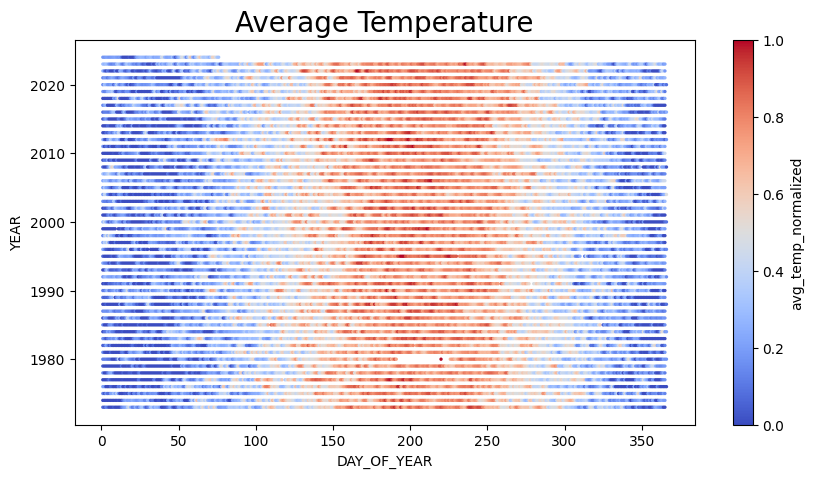

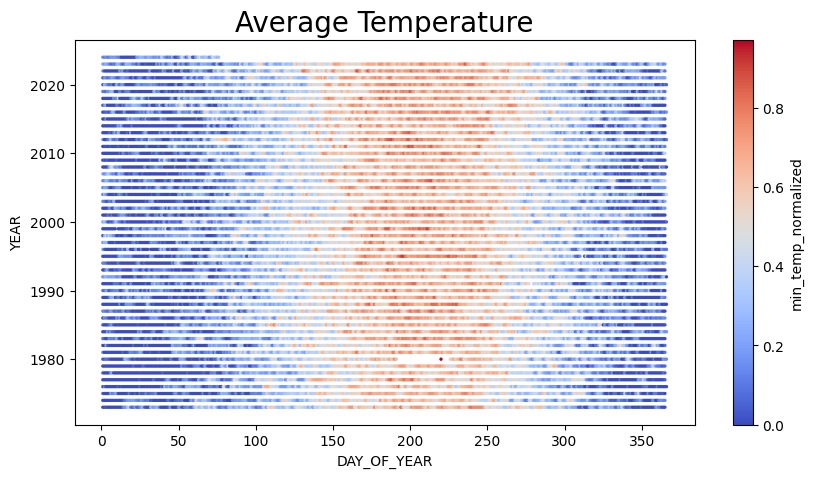

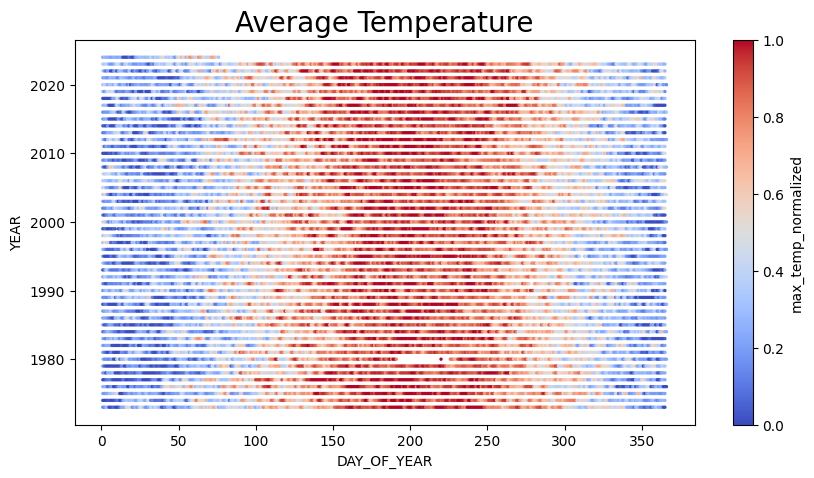

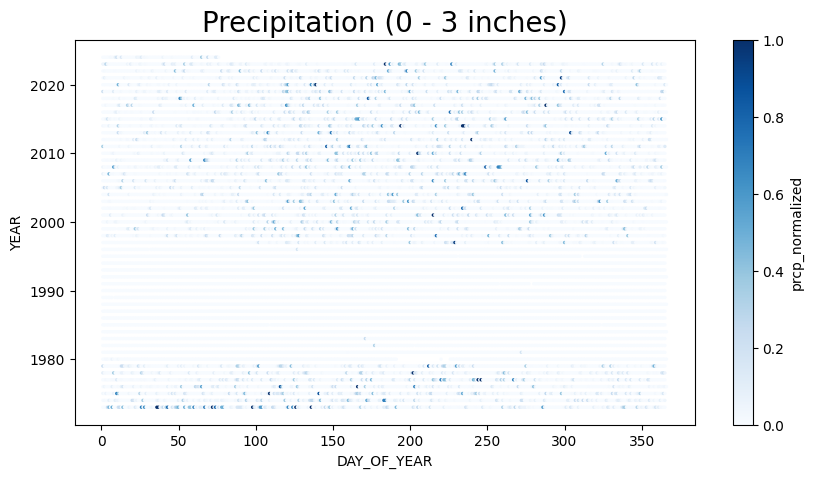

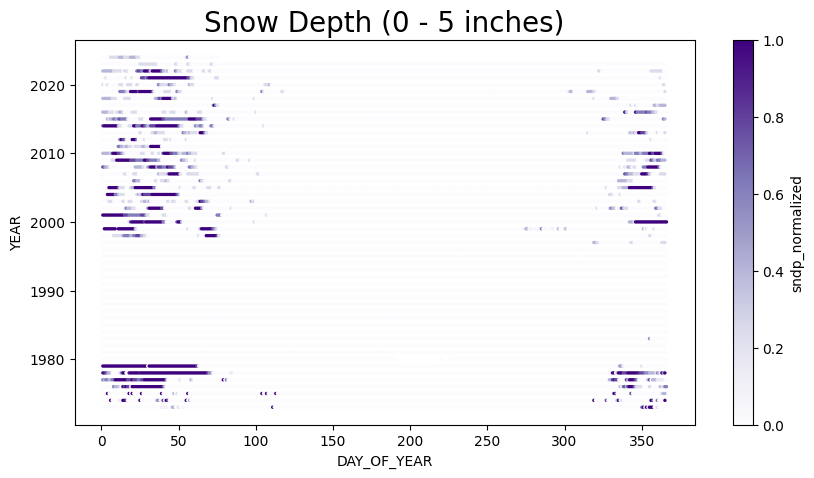

In [67]:
def normalize(day, value, min, max):
    normalized = (day[value] - min) / (max - min)
    if normalized < 0.0:
        normalized = 0.0
    if normalized > 1.0:
        normalized = 1.0
    return normalized
    
gsod['avg_temp_normalized'] = gsod.apply(lambda m: normalize(m, 'TEMP', 20, 90), axis=1)
gsod['min_temp_normalized'] = gsod.apply(lambda m: normalize(m, 'MIN', 20, 90), axis=1)
gsod['max_temp_normalized'] = gsod.apply(lambda m: normalize(m, 'MAX', 20, 90), axis=1)
gsod['prcp_normalized'] = gsod.apply(lambda m: normalize(m, 'PRCP', 0, 3), axis=1)
gsod['sndp_normalized'] = gsod.apply(lambda m: normalize(m, 'SNDP', 0, 5), axis=1)

def plotYearOverYear(column, colormap, title):
    ax = gsod.plot(x='DAY_OF_YEAR', y='YEAR', kind='scatter', s=2, c=column, colormap=colormap)
    ax.set_title(title, fontsize=20)

plotYearOverYear('avg_temp_normalized', 'coolwarm', 'Average Temperature')
plotYearOverYear('min_temp_normalized', 'coolwarm', 'Minimum Temperature')
plotYearOverYear('max_temp_normalized', 'coolwarm', 'Average Temperature')
plotYearOverYear('prcp_normalized', 'Blues', 'Precipitation (0 - 3 inches)')
plotYearOverYear('sndp_normalized', 'Purples', 'Snow Depth (0 - 5 inches)')

That's weird, it looks like there's missing `PRCP` and `SNDP` values for the years sometime after 1980 and sometime before 2000, although `TEMP` is available for that time range. If I were operating on precipitation or snow depth then this would be a problem, but for now I'm only interested in temperatures.

At this point, I have enough information to start exploring temperature trends in Chicago.